# Loading Data
Data for each of FY is present as a seperate sheet in the same excel file. We are using data for FY 20-21 and FY 21-22 for training and FY 22-23 for testing. Lets load the data for two training years as pandas dataframe and then concatenate them.

**Loading the training excel files.**

In [ ]:
import pandas as pd
df1 = pd.read_excel('/content/drive/MyDrive/CDIS Project/AEML/Actual Demand data_FY10-11 to Dec-23.xlsx',
                   sheet_name='FY20-21')
df1.columns = ['Date', 'Month', 'Time Block', 'Demand'] # Changing the column names.
df2 = pd.read_excel('/content/drive/MyDrive/CDIS Project/AEML/Actual Demand data_FY10-11 to Dec-23.xlsx',
                   sheet_name='FY21-22')
df2.columns = ['Date', 'Month', 'Time Block', 'Demand'] # Changing the column names.
train_df = pd.concat([df1, df2]) # Concatenating

# Checking if length of train_df matches.
assert len(train_df) == 365*2*24*60/15 # Two year, 24 hours in each day, 60 mins in each hour, data is present in 15 min intervals.

In [ ]:
train_df.head()

,Date,Month,Time Block,Demand
0,2020-04-01,4,1,1126.059592
1,2020-04-01,4,2,1115.611492
2,2020-04-01,4,3,1099.352080
3,2020-04-01,4,4,1087.579356
4,2020-04-01,4,5,1070.978124


**Loading the test excel files.**

In [ ]:
test_df = pd.read_excel('/content/drive/MyDrive/CDIS Project/AEML/Actual Demand data_FY10-11 to Dec-23.xlsx',
                        sheet_name='FY22-23')
test_df.columns = ['Date', 'Month', 'Time Block', 'Demand'] # Changing the column names.

In [ ]:
test_df.head()

,Date,Month,Time Block,Demand
0,2022-04-01,4,1,1474.614553
1,2022-04-01,4,2,1451.907380
2,2022-04-01,4,3,1426.388865
3,2022-04-01,4,4,1398.126644
4,2022-04-01,4,5,1366.145984


The month column is redundant, so lets drop it and then try to merge the time block with the date column.

In [ ]:
# Droping the Month Colomn
train_df = train_df.drop('Month', axis=1)

# Adding a column 'Time' with time data with 15 mins interval.
train_df['Time'] = [f"{h:02}:{m:02}" for h in range(24) for m in range(0, 60, 15)] * (len(train_df)//96) # Multiplying for 2 years

# Creating a new column with both Date and Time.
train_df['DateTime'] = train_df['Date'].astype(str) + ' ' + train_df['Time']

# Droping 'Date', 'Time', and 'Time Block' columns.
train_df = train_df.drop(['Date','Time', 'Time Block'], axis=1)

# Setting the 'DateTime' column as index.
train_df.set_index('DateTime', inplace=True)
train_df.index = pd.to_datetime(train_df.index) # Converting the index to datetime index
train_df.index.freq = '15min' # Setting the frequency to 15 mins.
train_df.head()

NameError: name 'train_df' is not defined

In [ ]:
# Droping the Month Colomn
test_df = test_df.drop('Month', axis=1)

# Adding a column 'Time' with time data with 15 mins interval.
test_df['Time'] = [f"{h:02}:{m:02}" for h in range(24) for m in range(0, 60, 15)] * (len(test_df)//96) # Multiplying for 2 years

# Creating a new column with both Date and Time.
test_df['DateTime'] = test_df['Date'].astype(str) + ' ' + test_df['Time']

# Droping 'Date', 'Time', and 'Time Block' columns.
test_df = test_df.drop(['Date','Time', 'Time Block'], axis=1)

# Setting the 'DateTime' column as index.
test_df.set_index('DateTime', inplace=True)
test_df.index = pd.to_datetime(test_df.index) # Converting the index to datetime index
test_df.index.freq = '15min' # Setting the frequency to 15 mins.
test_df.head()

,Demand
DateTime,
2022-04-01 00:00:00,1474.614553
2022-04-01 00:15:00,1451.907380
2022-04-01 00:30:00,1426.388865
2022-04-01 00:45:00,1398.126644
2022-04-01 01:00:00,1366.145984


## Plotting the data.

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 14.9 MB/s eta 0:00:00


**Training Data**

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(train_df)

ModuleNotFoundError: No module named 'sktime'

The above plot is difficult to interpret as we have 15min interval data. Lets plot the Total Demand for each day.



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Demand'>)

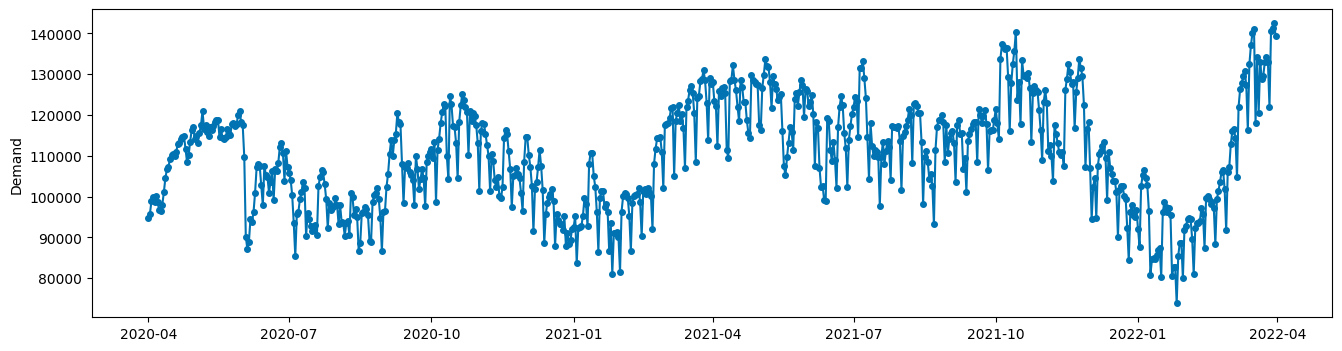

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(train_df.resample('D').sum()) # Summing up all values for the same day.

**Testing Data**

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Demand'>)

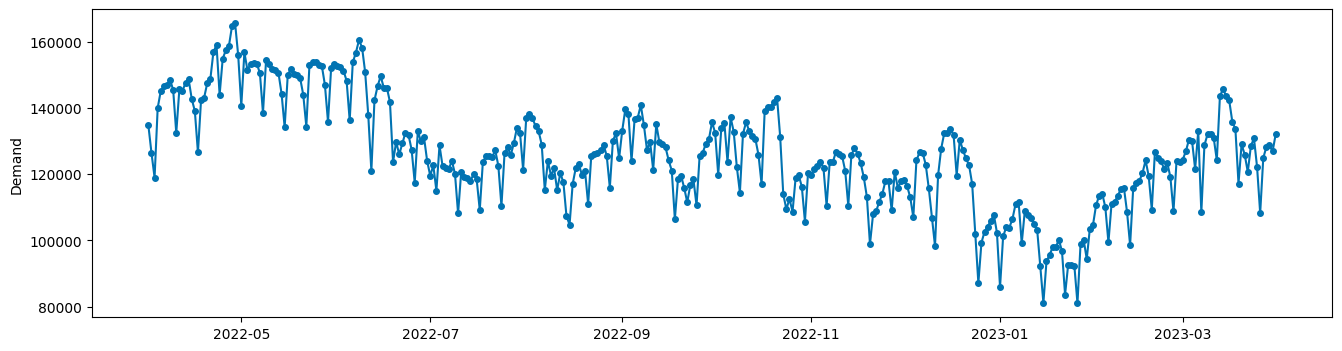

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(test_df.resample('D').sum()) # Summing up all values for the same day.

# Forecasting

## Theta Forecaster

### 15 Min Interval

In [ ]:
theta_train_df = train_df.copy()
theta_test_df = test_df.copy()

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
import numpy as np

# We need to define a Forecasting horizon.
# We are predicting for the next (len(test_df) +1 ) many values.
fh = ForecastingHorizon([i for i in range(1, len(theta_test_df) +1)], is_relative=True)

forecaster = ThetaForecaster(sp= 365 * 96) # Seasonal periodicity = Number of days * Number of time blocks in a day.
forecaster.fit(theta_train_df['Demand'].astype(np.float64)) # Fitting the Forecaster on the training data.
theta_test_df['Prediction'] = forecaster.predict(fh) # Predicting

Mean Absolute Percentage Error: 0.10504653576262853
Median Absolute Percentage Error: 0.08660644928671415


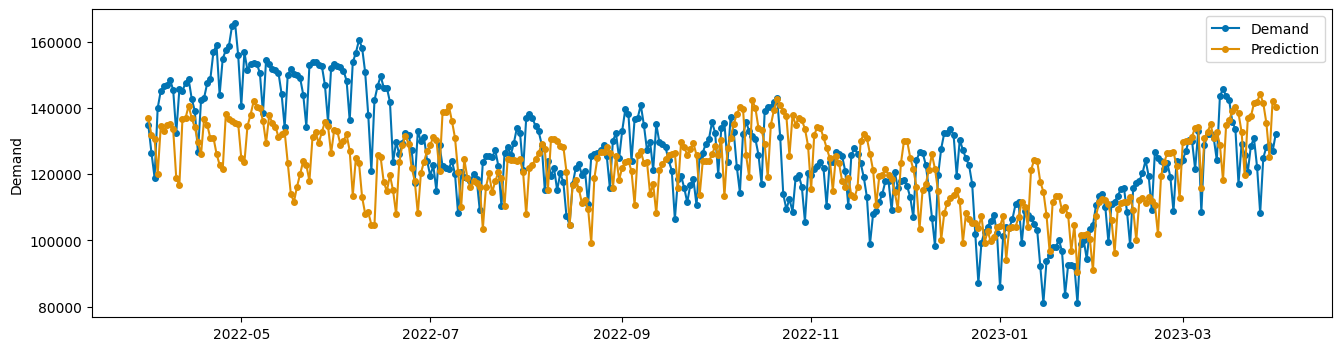

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import median_absolute_percentage_error, mean_absolute_percentage_error

# Plotting the actual Demand and Predicted Demand for each day.
plot_series(theta_test_df['Demand'].resample('D').sum(),theta_test_df['Prediction'].resample('D').sum(), labels=["Demand", "Prediction"])

# Caluculating the MAE
median_absolute_percentage_error = median_absolute_percentage_error(theta_test_df['Demand'], theta_test_df['Prediction'])
mean_absolute_percentage_error = mean_absolute_percentage_error(theta_test_df['Demand'], theta_test_df['Prediction'])
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error}")
print(f"Median Absolute Percentage Error: {median_absolute_percentage_error}")

### 1 Day Interval

In [ ]:
theta_train_df = train_df.resample('D').sum()
theta_test_df = test_df.resample('D').sum()

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
import numpy as np

# We need to define a Forecasting horizon.
# We are predicting for the next (len(test_df) +1 ) many values.
fh = ForecastingHorizon([i for i in range(1, len(theta_test_df) +1)], is_relative=True)

forecaster = ThetaForecaster(sp= 365) # Seasonal periodicity = Number of days * Number of time blocks in a day.
forecaster.fit(theta_train_df['Demand'].astype(np.float64)) # Fitting the Forecaster on the training data.
theta_test_df['Prediction'] = forecaster.predict(fh) # Predicting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Mean Absolute Percentage Error: 0.09610303416553545
Median Absolute Percentage Error: 0.08152988016412699


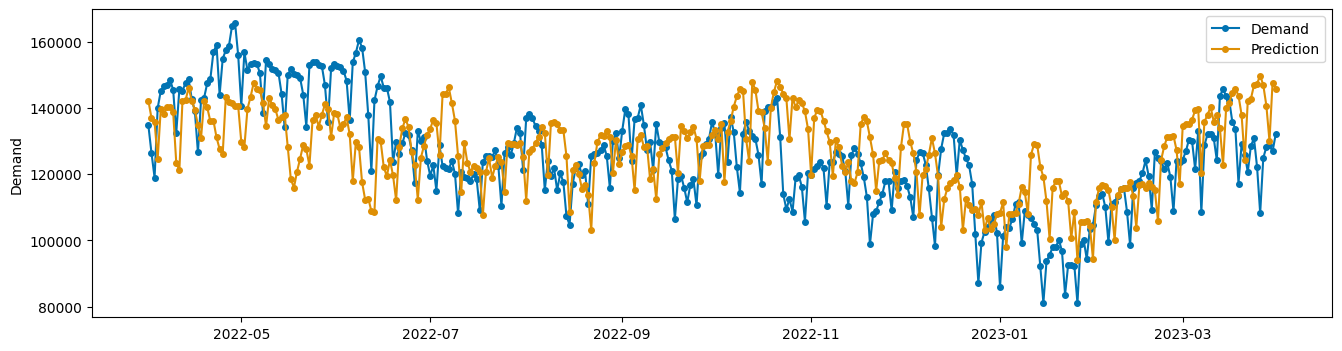

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import median_absolute_percentage_error, mean_absolute_percentage_error

# Plotting the actual Demand and Predicted Demand for each day.
plot_series(theta_test_df['Demand'].resample('D').sum(),theta_test_df['Prediction'].resample('D').sum(), labels=["Demand", "Prediction"])

# Caluculating the MAE
median_absolute_percentage_error = median_absolute_percentage_error(theta_test_df['Demand'], theta_test_df['Prediction'])
mean_absolute_percentage_error = mean_absolute_percentage_error(theta_test_df['Demand'], theta_test_df['Prediction'])
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error}")
print(f"Median Absolute Percentage Error: {median_absolute_percentage_error}")

## AutoArima
I keep running out of memory when trying to fit AutoArima on 15 min interval data. Creating new data by summing up all the demand for a day.

In [ ]:
# arima_train_df = train_df.resample('D').sum()
# arima_test_df = test_df.resample('D').sum()

arima_train_df = train_df.copy()
arima_test_df = test_df.copy()

In [ ]:
len(arima_train_df), len(arima_test_df)

(730, 365)

In [ ]:
! pip install pmdarima
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
import numpy as np

# We need to define a Forecasting horizon.
# We are predicting for the next (len(test_df) +1 ) many values.
fh = ForecastingHorizon([i for i in range(1, len(arima_test_df) +1)], is_relative=True)

forecaster = AutoARIMA()
    # sp=365,
#                        suppress_warnings=True)
                      # max_p=3,  # Maximum order for AR terms
                      # max_q=3,  # Maximum order for MA terms
                      # max_d=2,  # Maximum degree of differencing
                      # seasonal=True,  # Enable seasonal components
                      # max_P=2,  # Maximum seasonal AR order
                      # max_Q=2,  # Maximum seasonal MA order
                      # max_D=1)   # Maximum seasonal differencing) # Seasonal periodicity = Number of days * Number of time blocks in a day.
forecaster.fit(arima_train_df['Demand'].astype(np.float32)) # Fitting the Forecaster on the training data.
arima_test_df['Prediction'] = forecaster.predict(fh) # Predicting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

Mean Absolute Percentage Error: 0.1584117672692639


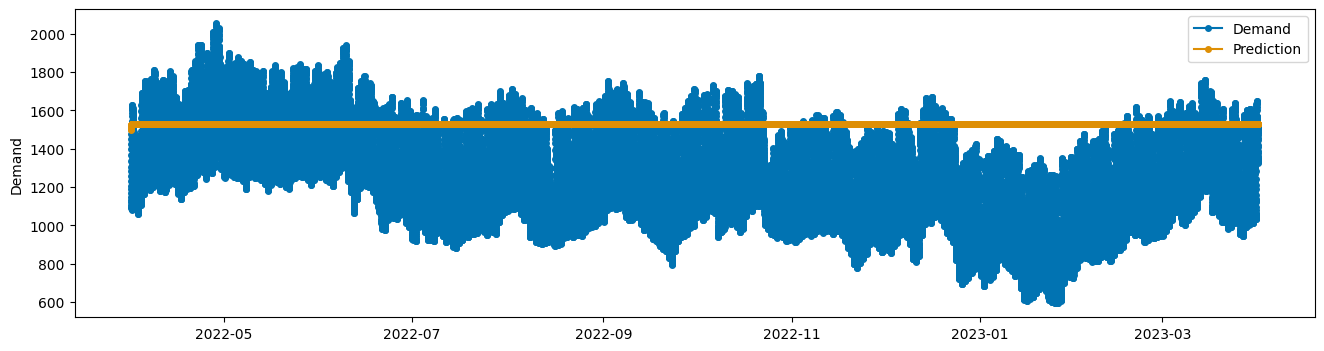

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import median_absolute_percentage_error

# Plotting the actual Demand and Predicted Demand for each day.
plot_series(arima_test_df['Demand'],arima_test_df['Prediction'], labels=["Demand", "Prediction"])

# Caluculating the MAE
mean_absolute_percentage_error = median_absolute_percentage_error(arima_test_df['Demand'], arima_test_df['Prediction'])
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error}")

## Sktime Prophet

### 15 Min Intervals

In [ ]:
prophet_train_df = train_df.copy()
prophet_test_df = test_df.copy()

NameError: name 'train_df' is not defined

In [ ]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
import numpy as np

fh = ForecastingHorizon([i for i in range(1, len(prophet_test_df) +1)], is_relative=True)
forecaster = Prophet(yearly_seasonality = True,
                      add_country_holidays={'country_name': 'India'})
forecaster.fit(prophet_train_df['Demand'].astype(np.float32))

# Generate predictions
prophet_test_df['Predictions'] = forecaster.predict(fh)

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:103: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_whqqkn/f5e4pzip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_whqqkn/mo3w3x4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48694', 'data', 'file=/tmp/tmpr_whqqkn/f5e4pzip.json', 'init=/tmp/tmpr_whqqkn/mo3w3x4c.json', 'output', 'file=/tmp/tmpr_whqqkn/prophet_model71esi0oi/prophet_model-20241203055516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:55:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Percentage Error: 0.2924830242440929
Median Absolute Percentage Error: 0.26301499725994093


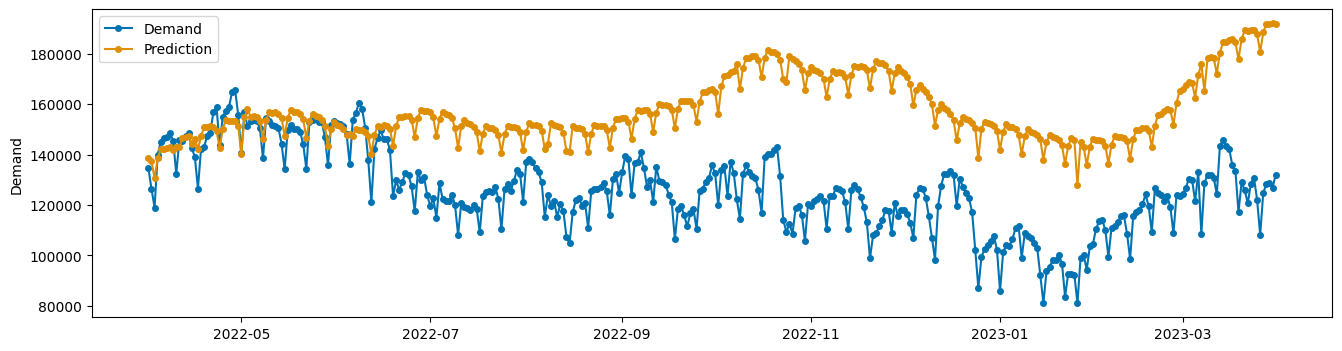

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import median_absolute_percentage_error, mean_absolute_percentage_error

# Plotting the actual Demand and Predicted Demand for each day.
plot_series(prophet_test_df['Demand'].resample('D').sum(),prophet_test_df['Predictions'].resample('D').sum(), labels=["Demand", "Prediction"])

# Caluculating the MAE
median_absolute_percentage_error = median_absolute_percentage_error(prophet_test_df['Demand'], prophet_test_df['Predictions'])
mean_absolute_percentage_error = mean_absolute_percentage_error(prophet_test_df['Demand'], prophet_test_df['Predictions'])
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error}")
print(f"Median Absolute Percentage Error: {median_absolute_percentage_error}")

### 1 Day Intervals

In [ ]:
prophet_train_df = train_df.resample('D').sum()
prophet_test_df = test_df.resample('D').sum()

In [ ]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
import numpy as np

fh = ForecastingHorizon([i for i in range(1, len(prophet_test_df) +1)], is_relative=True)
forecaster = Prophet(yearly_seasonality = True,
                      add_country_holidays={'country_name': 'India'})
forecaster.fit(prophet_train_df['Demand'].astype(np.float32))

# Generate predictions
prophet_test_df['Predictions'] = forecaster.predict(fh)

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:103: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_whqqkn/vvsxj3wt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_whqqkn/d4rd5bj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97492', 'data', 'file=/tmp/tmpr_whqqkn/vvsxj3wt.json', 'init=/tmp/tmpr_whqqkn/d4rd5bj1.json', 'output', 'file=/tmp/tmpr_whqqkn/prophet_modelkueorz_w/prophet_model-20241203055915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:59:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:59:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Mean Absolute Percentage Error: 0.10973639073805834
Median Absolute Percentage Error: 0.11084918526022113


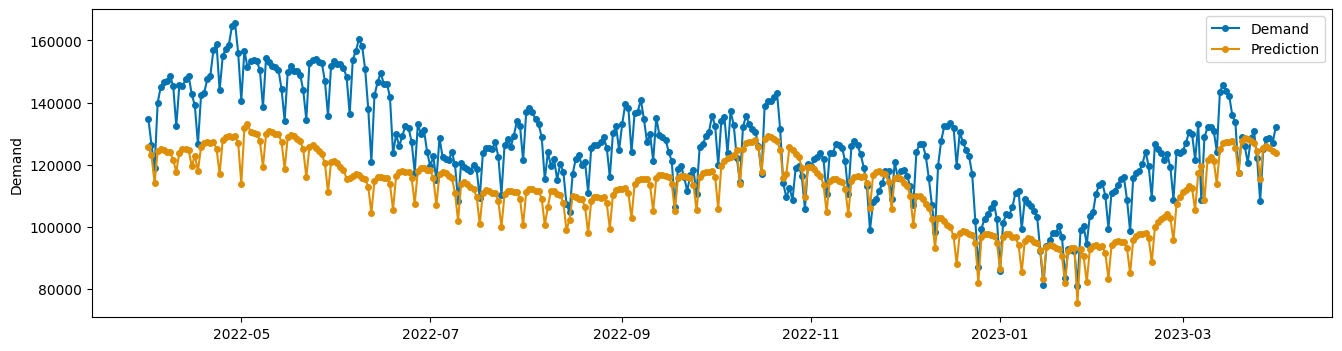

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import median_absolute_percentage_error, mean_absolute_percentage_error

# Plotting the actual Demand and Predicted Demand for each day.
plot_series(prophet_test_df['Demand'].resample('D').sum(),prophet_test_df['Predictions'].resample('D').sum(), labels=["Demand", "Prediction"])

# Caluculating the MAE
median_absolute_percentage_error = median_absolute_percentage_error(prophet_test_df['Demand'], prophet_test_df['Predictions'])
mean_absolute_percentage_error = mean_absolute_percentage_error(prophet_test_df['Demand'], prophet_test_df['Predictions'])
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error}")
print(f"Median Absolute Percentage Error: {median_absolute_percentage_error}")

## Prophet

In [ ]:
import pandas as pd
# from fbprophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

ex_df1 = pd.read_excel('/content/drive/MyDrive/CDIS Project/AEML/Weather Master From FY19-20 to Dec-23.xlsx',
                       sheet_name='FY20-21')
ex_df2 = pd.read_excel('/content/drive/MyDrive/CDIS Project/AEML/Weather Master From FY19-20 to Dec-23.xlsx',
                       sheet_name='FY21-22')
ex_df33 = pd.read_excel('/content/drive/MyDrive/CDIS Project/AEML/Weather Master From FY19-20 to Dec-23.xlsx',
                       sheet_name='FY22-23')


In [ ]:
ex_df1.columns

Index(['Date', 'Time Block', 'FORE_TEMP', 'ACT_TEMP', 'FORE_HUMIDITY',
       'ACT_HUMIDITY', 'FORE_WINDSPEED', 'ACT_WINDSPEED',
       'FORE_WIND_DIRECTION', 'ACT_WIND_DIRECTION', 'FORE_CLOUD', 'ACT_CLOUD',
       'FORE_WEATHER', 'ACT_WEATHER', 'FORE_RAINRATE', 'ACT_RAINRATE'],
      dtype='object')

In [ ]:
ex_df = pd.concat([ex_df1, ex_df2])
ex_df = ex_df.loc[:,['Date','ACT_TEMP', 'ACT_HUMIDITY', 'ACT_WINDSPEED', 'ACT_CLOUD']]

# Adding a column 'Time' with time data with 15 mins interval.
ex_df['Time'] = [f"{h:02}:{m:02}" for h in range(24) for m in range(0, 60, 15)] * (len(ex_df)//96) # Multiplying for 2 years

# Creating a new column with both Date and Time.
ex_df['DateTime'] = ex_df['Date'].astype(str) + ' ' + ex_df['Time']

# Droping 'Date', 'Time', and 'Time Block' columns.
ex_df = ex_df.drop(['Date','Time'], axis=1)

# Setting the 'DateTime' column as index.
ex_df.set_index('DateTime', inplace=True)
ex_df.index = pd.to_datetime(ex_df.index) # Converting the index to datetime index
ex_df.index.freq = '15min' # Setting the frequency to 15 mins.
ex_df.fillna(ex_df.min(), inplace = True)
ex_df.head()

,ACT_TEMP,ACT_HUMIDITY,ACT_WINDSPEED,ACT_CLOUD
DateTime,,,,
2020-04-01 00:00:00,27.11,80.99,0.03,1.0
2020-04-01 00:15:00,27.23,81.33,0.27,1.0
2020-04-01 00:30:00,27.26,81.03,0.05,1.0
2020-04-01 00:45:00,27.20,81.18,0.25,1.0
2020-04-01 01:00:00,27.13,81.80,0.08,1.0


In [ ]:
ex_df3 = ex_df33.loc[:,['Date','ACT_TEMP', 'ACT_HUMIDITY', 'ACT_WINDSPEED', 'ACT_CLOUD']]

# Adding a column 'Time' with time data with 15 mins interval.
ex_df3['Time'] = [f"{h:02}:{m:02}" for h in range(24) for m in range(0, 60, 15)] * (len(ex_df3)//96) # Multiplying for 2 years

# Creating a new column with both Date and Time.
ex_df3['DateTime'] = ex_df3['Date'].astype(str) + ' ' + ex_df3['Time']

# Droping 'Date', 'Time', and 'Time Block' columns.
ex_df3 = ex_df3.drop(['Date','Time'], axis=1)

# Setting the 'DateTime' column as index.
ex_df3.set_index('DateTime', inplace=True)
ex_df3.index = pd.to_datetime(ex_df3.index) # Converting the index to datetime index
ex_df3.index.freq = '15min' # Setting the frequency to 15 mins.
ex_df3.fillna(0, inplace = True)
ex_df3.head()

,ACT_TEMP,ACT_HUMIDITY,ACT_WINDSPEED,ACT_CLOUD
DateTime,,,,
2022-04-01 00:00:00,26.64,79,0.00,0.0
2022-04-01 00:15:00,26.36,79,0.00,0.0
2022-04-01 00:30:00,26.10,80,0.01,0.0
2022-04-01 00:45:00,26.18,80,0.00,0.0
2022-04-01 01:00:00,26.04,81,0.00,0.0


### 15 Min Interval

In [ ]:
prophet_train_df = pd.concat([train_df, ex_df], axis=1)
prophet_test_df = pd.concat([test_df, ex_df3], axis=1)


In [ ]:
ex_df3

,ACT_TEMP,ACT_HUMIDITY,ACT_WINDSPEED,ACT_CLOUD
DateTime,,,,
2022-04-01 00:00:00,26.64,79,0.00,0.0
2022-04-01 00:15:00,26.36,79,0.00,0.0
2022-04-01 00:30:00,26.10,80,0.01,0.0
2022-04-01 00:45:00,26.18,80,0.00,0.0
2022-04-01 01:00:00,26.04,81,0.00,0.0
...,...,...,...,...
2022-12-31 22:45:00,23.02,57,0.00,0.0
2022-12-31 23:00:00,22.74,59,0.00,0.0
2022-12-31 23:15:00,22.62,61,0.00,0.0


In [ ]:
from prophet import Prophet

model = Prophet()
model.add_country_holidays(country_name='India')
model.add_regressor('ACT_TEMP')
model.add_regressor('ACT_HUMIDITY')
model.add_regressor('ACT_WINDSPEED')
model.add_regressor('ACT_CLOUD')
model.fit(prophet_train_df.reset_index().rename(columns={'index': 'ds', 'Demand': 'y'}))


/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:103: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzks7c8i8/3u_farr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzks7c8i8/x3pc8fjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81622', 'data', 'file=/tmp/tmpzks7c8i8/3u_farr1.json', 'init=/tmp/tmpzks7c8i8/x3pc8fjh.json', 'output', 'file=/tmp/tmpzks7c8i8/prophet_modelnxrj_hw_/prophet_model-20241204082545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:14 - cmdstanpy - INFO - Chain [1] done processing
INF

In [ ]:
prophet_test_df

,Demand,ACT_TEMP,ACT_HUMIDITY,ACT_WINDSPEED,ACT_CLOUD
DateTime,,,,,
2022-04-01 00:00:00,1474.614553,26.64,79.0,0.00,0.0
2022-04-01 00:15:00,1451.907380,26.36,79.0,0.00,0.0
2022-04-01 00:30:00,1426.388865,26.10,80.0,0.01,0.0
2022-04-01 00:45:00,1398.126644,26.18,80.0,0.00,0.0
2022-04-01 01:00:00,1366.145984,26.04,81.0,0.00,0.0
...,...,...,...,...,...
2023-03-31 22:45:00,1347.293286,NaN,NaN,NaN,NaN
2023-03-31 23:00:00,1340.936102,NaN,NaN,NaN,NaN
2023-03-31 23:15:00,1339.039369,NaN,NaN,NaN,NaN


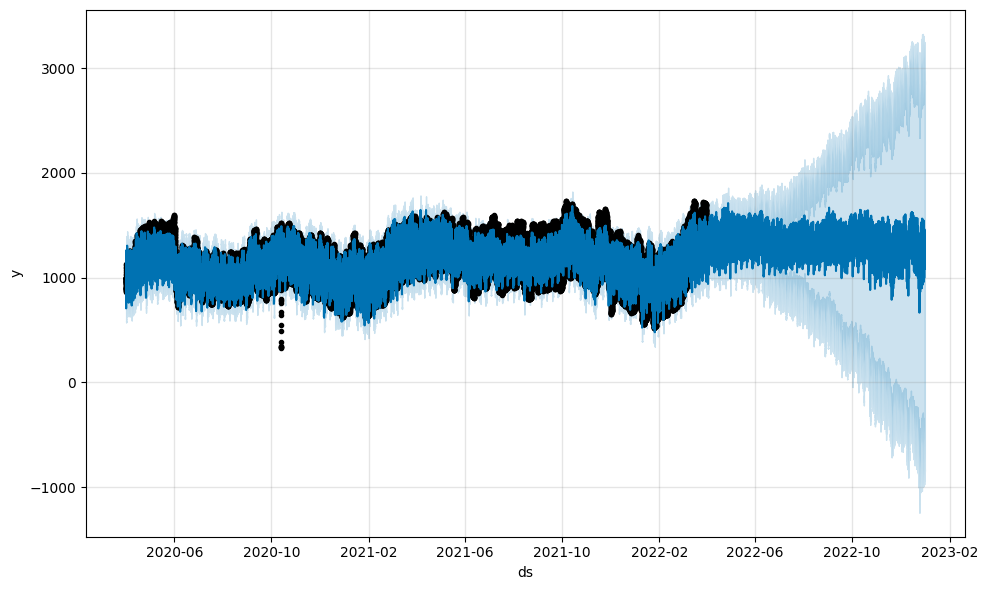

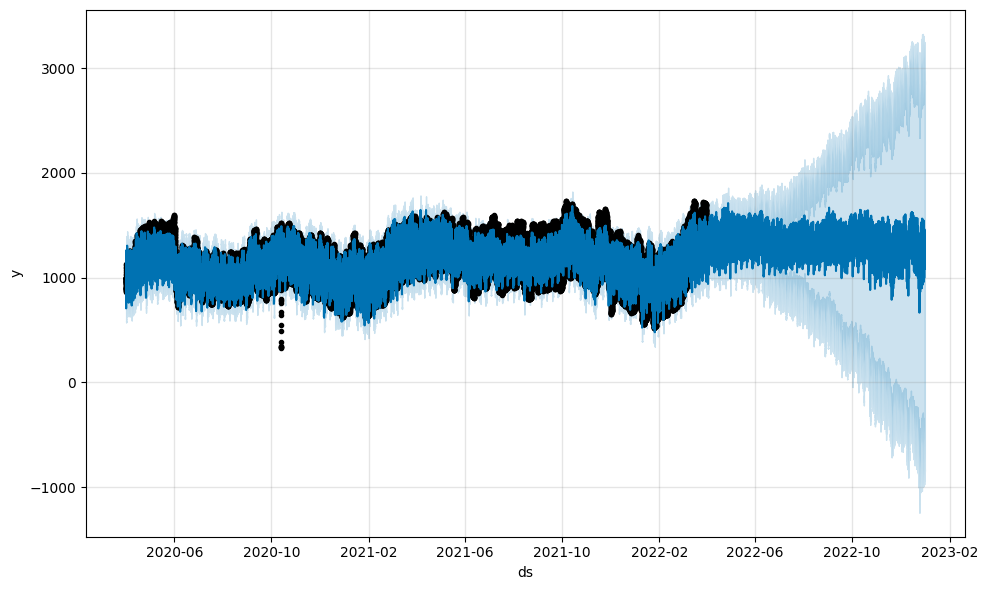

In [ ]:
# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=275*96, freq='15min')

future['ACT_TEMP'] = list(prophet_train_df['ACT_TEMP']) + list(prophet_test_df.iloc[:275*96]['ACT_TEMP'])  # Provide future values
future['ACT_HUMIDITY'] = prophet_train_df['ACT_HUMIDITY'].to_list() +  prophet_test_df.iloc[:275*96]['ACT_HUMIDITY'].to_list()  # Provide future values
future['ACT_WINDSPEED'] = prophet_train_df['ACT_WINDSPEED'].to_list() +  prophet_test_df.iloc[:275*96]['ACT_WINDSPEED'].to_list()  # Provide future values
future['ACT_CLOUD'] = prophet_train_df['ACT_CLOUD'].to_list() +  prophet_test_df.iloc[:275*96]['ACT_CLOUD'].to_list()  # Provide future values
# Make predictions
forecast = model.predict(future )
# Plot the forecast
model.plot(forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sktime.performance_metrics.forecasting import median_absolute_percentage_error, mean_absolute_percentage_error

test_predictions = forecast.iloc[-275*96:]['yhat']
prophet_test_df = prophet_test_df.iloc[:275*96]['Demand']

# Calculate MAE
mae = mean_absolute_percentage_error(prophet_test_df, test_predictions)
median_absolute_percentage_error = median_absolute_percentage_error(prophet_test_df, test_predictions)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Percentage Error: {median_absolute_percentage_error}")

ModuleNotFoundError: No module named 'sktime'

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Demand'>)

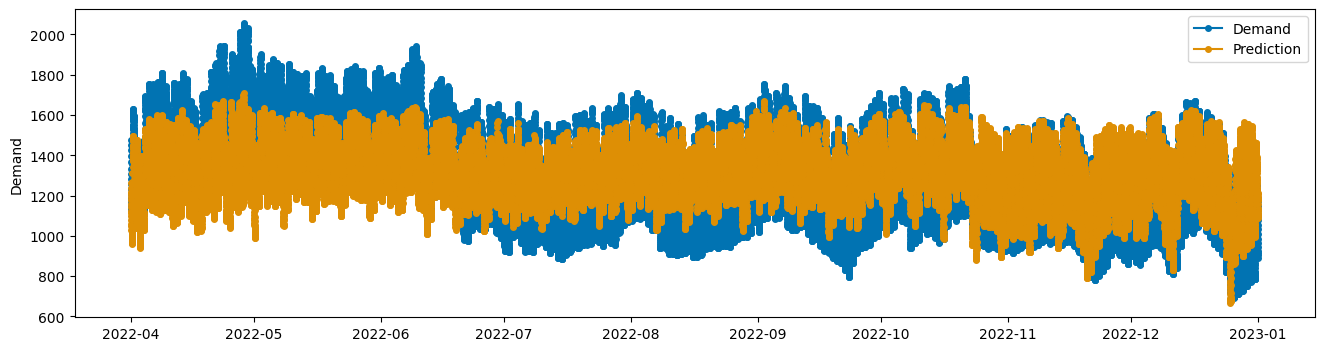

In [ ]:
test_predictions.index = prophet_test_df.index
plot_series(prophet_test_df,test_predictions, labels=['Demand', 'Prediction'])

### 1 Day Interval

In [ ]:
prophet_train_df = train_df.resample('D').sum()
prophet_test_df = test_df.resample('D').sum()
prophet_train_df['ACT_HUMIDITY'] = ex_df.resample('D').mean()['ACT_HUMIDITY']
prophet_train_df['ACT_TEMP'] = ex_df.resample('D').mean()['ACT_TEMP']
prophet_train_df['ACT_WINDSPEED'] = ex_df.resample('D').mean()['ACT_WINDSPEED']
prophet_train_df['ACT_CLOUD'] = ex_df.resample('D').mean()['ACT_CLOUD']
prophet_test_df['ACT_HUMIDITY'] = ex_df3.resample('D').mean()['ACT_HUMIDITY']
prophet_test_df['ACT_TEMP'] = ex_df3.resample('D').mean()['ACT_TEMP']
prophet_test_df['ACT_WINDSPEED'] = ex_df3.resample('D').mean()['ACT_WINDSPEED']
prophet_test_df['ACT_CLOUD'] = ex_df3.resample('D').mean()['ACT_CLOUD']

In [ ]:
prophet_train_df

,Demand,ACT_HUMIDITY,ACT_TEMP,ACT_WINDSPEED,ACT_CLOUD
2020-04-01,94670.659332,68.690625,29.846667,2.288021,1.000000
2020-04-02,95810.152420,68.035625,30.521563,2.160833,1.031250
2020-04-03,98921.181144,70.243229,30.415104,2.769479,1.000000
2020-04-04,99889.942904,73.733750,30.180625,2.760312,1.000000
2020-04-05,98662.230920,76.443021,29.847812,1.917187,1.000000
...,...,...,...,...,...
2022-03-27,121984.333555,71.656250,28.855625,0.563437,1.083333
2022-03-28,140606.616819,73.989583,29.338437,0.598229,0.541667
2022-03-29,141250.988441,64.270833,30.267188,0.543542,-0.208333
2022-03-30,142504.659527,68.416667,29.657604,0.507917,0.000000


In [ ]:
from prophet import Prophet

model = Prophet()
model.add_country_holidays(country_name='India')
model.add_regressor('ACT_TEMP')
model.add_regressor('ACT_HUMIDITY')
model.add_regressor('ACT_WINDSPEED')
model.add_regressor('ACT_CLOUD')
model.fit(prophet_train_df.reset_index().rename(columns={'index': 'ds', 'Demand': 'y'}))


/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:103: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzks7c8i8/3i4g1r02.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzks7c8i8/0ugoyuku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12777', 'data', 'file=/tmp/tmpzks7c8i8/3i4g1r02.json', 'init=/tmp/tmpzks7c8i8/0ugoyuku.json', 'output', 'file=/tmp/tmpzks7c8i8/prophet_modelcyk82brb/prophet_model-20241204082817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:17 - cmdstanpy - INFO - Chain [1] start processing
I

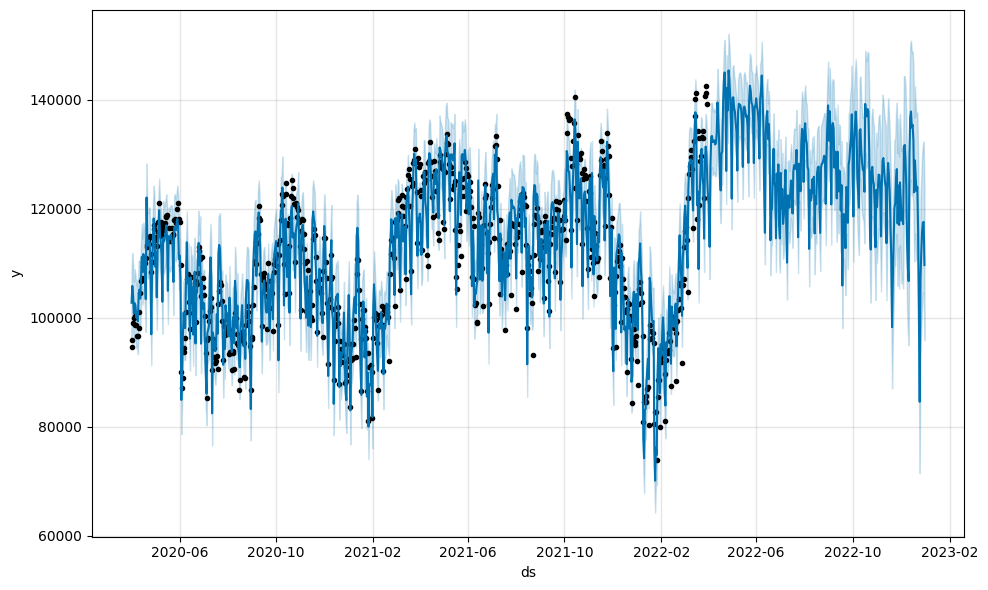

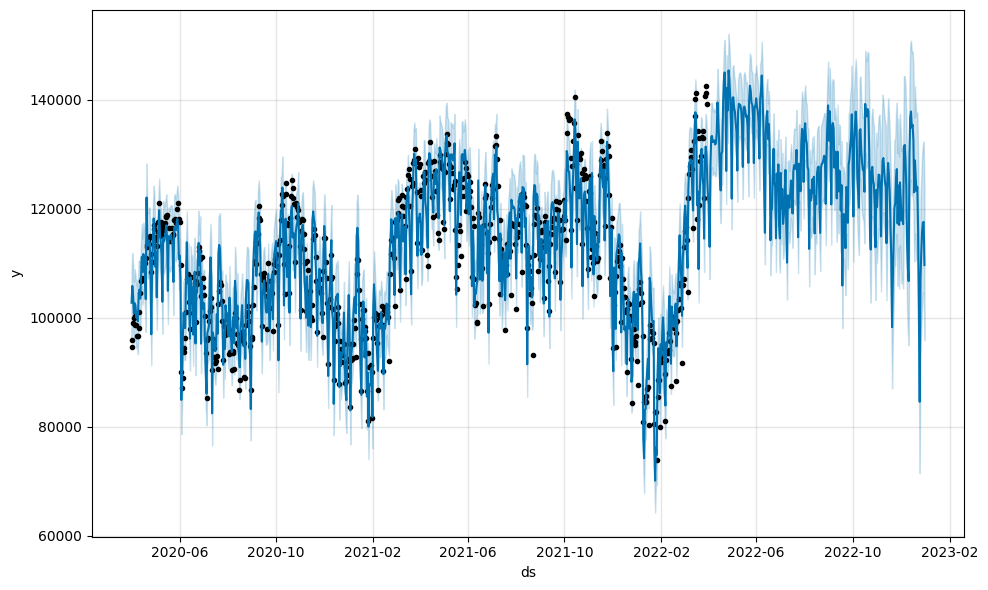

In [ ]:
# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=275, freq='D')

future['ACT_TEMP'] = list(prophet_train_df['ACT_TEMP']) + list(prophet_test_df.iloc[:275]['ACT_TEMP'])  # Provide future values
future['ACT_HUMIDITY'] = prophet_train_df['ACT_HUMIDITY'].to_list() +  prophet_test_df.iloc[:275]['ACT_HUMIDITY'].to_list()  # Provide future values
future['ACT_WINDSPEED'] = prophet_train_df['ACT_WINDSPEED'].to_list() +  prophet_test_df.iloc[:275]['ACT_WINDSPEED'].to_list()  # Provide future values
future['ACT_CLOUD'] = prophet_train_df['ACT_CLOUD'].to_list() +  prophet_test_df.iloc[:275]['ACT_CLOUD'].to_list()  # Provide future values

# Make predictions
forecast = model.predict(future )
# Plot the forecast
model.plot(forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sktime.performance_metrics.forecasting import median_absolute_percentage_error, mean_absolute_percentage_error

test_predictions = forecast.iloc[-275:]['yhat']
prophet_test_df = prophet_test_df.iloc[:275]['Demand']

# Calculate MAE
mae = mean_absolute_percentage_error(prophet_test_df, test_predictions)
median_absolute_percentage_error = median_absolute_percentage_error(prophet_test_df, test_predictions)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Percentage Error: {median_absolute_percentage_error}")

Mean Absolute Error (MAE): 0.04744514574241739
Median Absolute Percentage Error: 0.03941473398912535


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Demand'>)

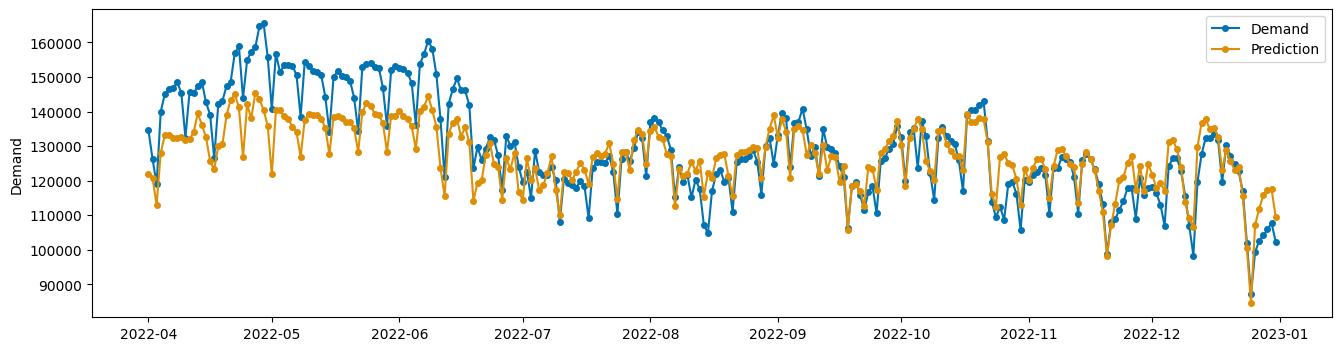

In [ ]:
test_predictions.index = prophet_test_df.index
plot_series(prophet_test_df,test_predictions, labels=['Demand', 'Prediction'])